In [2]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from Library import ka, Create_MPO, Create_random_MPS, Pauli, Model_coefficients, i_trunc

data_type=np.complex128


d = 2
L = 80        # system size
chi_max = 8          # Maximal bond dimension                            
n = 100   # Number of zips
h_x, h_y, h_z = 0.5, 0.9, 0.5  # Field in the different directions
J_xx, J_yy, J_zz = 1.5, 0.2, 1.5  # Strength of spin interactions
Model = [["z"],["x"]]     # The first part of the model gives us the spin interaction and the second one the fields
chi_MPO = len(Model[0]) + 2 
t = 8
chis = ka(L,chi_max)

S_z, S_x, S_y, S1 = Pauli()
Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)
 
def H_mult(v):
    return np.matmul(H,v)


In [3]:
from numpy.random import random as rnd
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import eigsh
import cProfile
import pstats
np.random.seed(121)

# Create MPO
W = Create_MPO(Model,S1,Interactions,Fields,chi_MPO, data_type)
# Create the MPS
X, V = Create_random_MPS(L,chis)

v_L,v_R=np.zeros(chi_MPO,dtype=data_type),np.zeros(chi_MPO,dtype=data_type)
v_L[0],v_R[-1]=1.,1. 

L_env,R_env=np.zeros((chi_max,chi_MPO,chi_max),dtype=data_type),np.zeros((chi_max,chi_MPO,chi_max),dtype=data_type)

L_env=np.einsum("ab,c->acb",np.eye(chi_max,dtype=data_type),v_L)         # Initial Righ and left environments
R_env=np.einsum("ab,c->acb",np.eye(chi_max,dtype=data_type),v_R)

Gamma=[X[L//2],X[L//2+1]]
lam=[V[L//2],V[L//2]]

A = np.zeros((chi_max,d,chi_max),dtype=data_type)
B = np.zeros((chi_max,d,chi_max),dtype=data_type)

A = np.einsum("a,aib->aib",lam[0],Gamma[0])
B = np.einsum("aib,b->aib",Gamma[1],lam[0])

H=np.einsum("abc,bdij->adijc",L_env,W)
H=np.einsum("adijc,dekl->aekl ijc",H,W)
H=np.einsum("aeklijc,feg->aikf cjlg",H,R_env).reshape((chi_max*chi_max*d**2,chi_max*chi_max*d**2))

Ener=np.zeros(n).astype(data_type)      # Initialize energy per site
Ener1=np.zeros(n).astype(data_type)     # Initialize energy array

print("start")

for i in range(n):
    if i%10 == 0:
       print(i)
    # Update Hamiltonian
    H=np.einsum("abc,bdij->adijc",L_env,W)
    H=np.einsum("adijc,dekl->aekl ijc",H,W)
    H=np.einsum("aekl ijc,feg->aikf cjlg",H,R_env).reshape((chi_max*chi_max*d**2,chi_max*chi_max*d**2))
    
    As = LinearOperator((chi_max*chi_max*d**2,chi_max*chi_max*d**2), matvec=H_mult,dtype=data_type)
    
    Theta = np.einsum("aib,b,bjc->aijc",A,lam[1],B).reshape(chi_max*chi_max*d**2)
    
    # Find ground state
    w, v = eigsh(As,k=1,v0=Theta,which="SA")

    Theta_p = v[:,0].reshape(chi_max*d,chi_max*d)
    Theta_p/=LA.norm(Theta_p)
    # Truncate
    A,lamb,B=i_trunc(chi_max,Theta_p,d=d)
    lam[1]=lamb

    #Updating the left and right environments
    L_env=np.einsum("amb,aic->mbic",L_env,A)   
    L_env=np.einsum("mbic,mlij->bclj",L_env,W)   
    L_env=np.einsum("bclj,bjd->cld",L_env,np.conj(A))

    R_env=np.einsum("amb,cia->mbci",R_env,B)
    R_env=np.einsum("mbci,lmij->bclj",R_env,W)
    R_env=np.einsum("bclj,djb->cld",R_env,np.conj(B))

    # 2-site wave function
    Upper=np.einsum("aib,b,bjc->aijc",A,lam[1],B)

    # Compute energy
    Ener01=np.einsum("amc,aikb->ikbmc",L_env,Upper)
    Ener02=np.einsum("ikbmc,mlij->ljkbc",Ener01,W)
    Ener03=np.einsum("ljkbc,ldkv->jdbvc",Ener02,W)
    Ener04=np.einsum("jdbvc,cjvh->dbh",Ener03,np.conj(Upper))
    Ener[i]=np.einsum("dbh,bdh->",Ener04,R_env)
    Ener1[i]=Ener[i]/2/(i+1)

start
0
10
20
30
40
50
60
70
80
90


(-1.5211474566590975+2.6267108825273777e-16j)


c:\Users\hgton\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


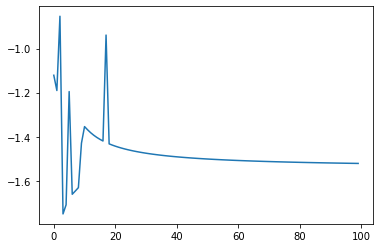

In [4]:
plt.plot(Ener1)
print(Ener1[-1])